[En français](../use-case_oafeat-script_fr/)  

![ECCC logo](https://eccc-msc.github.io/open-data/img_eccc-logo.png)  

[TOC](https://eccc-msc.github.io/open-data/readme_en/) > [Usage overview](https://eccc-msc.github.io/open-data/usage/readme_en/) > OGC API - Features request in Python (script version)

# Use Case: Retrieving and Displaying Hydrometric Data

## Introduction

Hydrometric data from the Meteorological Service of Canada (MSC), Environment and Climate Change Canada (ECCC) can be easily accessed via [GeoMet-OGC-API](https://api.weather.gc.ca/). The [OGC API - Features](https://eccc-msc.github.io/open-data/msc-geomet/web-services_en/#ogc-api-features) web services available in GeoMet-OGC-API offer the capability to query vector geospatial data and retrieve it in a GeoJSON format. The GeoJSON output file can then be used for display or further data processing. This use case will show you how you can:
* Query and retrieve vector geospatial data from GeoMet-OGC-API with [Python](https://www.python.org/)
* Display time series data in graphic and tabular format
* Create an interactive map to display geospatial data

This use case comes in two different versions. This version is designed to be run in a terminal or an IDE but can also be used [in a Jupyter Notebook](https://mybinder.org/v2/gh/marieevelb/oafeat-use-case/main?filepath=docs%2Fuse-case_oafeat-script_en.ipynb). If you are looking for more interactive features like dropdown menus to choose variables' values, an interactive plot with a variety of controls and an interactive map based on Leaflet, [the other version of this use case](https://mybinder.org/v2/gh/marieevelb/oafeat-use-case/main?filepath=docs%2Fuse-case_oafeat-interactive_en.ipynb) that is conceived specifically for Jupyter Notebook might interest you.

[An executable version of this use case is available.](https://mybinder.org/v2/gh/marieevelb/oafeat-use-case/main?filepath=docs%2Fuse-case_oafeat-script_en.ipynb) In Jupyter Notebook, click on the ⏩️ symbol or select the Cell -> Run All option in the menu bar to run the entire notebook. If the annotations are not visible on the plot or the map when hovering over data points, run the plot or the map code cell again by clicking in the desired cell and then clicking on the Run button in the menu bar.

**Important note:** Outside of a Jupyter Notebook, the ```%matplotlib notebook``` magic command located at the end of the parameters section of the code needs to be removed.

[![badge](https://img.shields.io/badge/Executable%20version-binder-F5A252.svg?logo=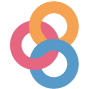)](https://mybinder.org/v2/gh/marieevelb/oafeat-use-case/main?filepath=docs%2Fuse-case_oafeat-script_en.ipynb)


## Creation of a tool to monitor water levels

Cathy runs a boat tours and water sports company in Chilliwack, British-Columbia. She would like to track the water levels of a few hydrometric stations near her city to guide the management of the company's activities. She would like to have:
* The daily mean water levels of a three months period for all hydrometric stations located within 100 km of the city of Chilliwack
* Graphic and tabular views that present the mean water levels of that three months period
* An interactive map that displays the hydrometric stations located within 100 km of the city of Chilliwack and the most recent daily mean water level of these stations in the determined time period

To achieve this, the first step is to import the necessary Python modules and to select the desired request parameters.

In [1]:
# Modules importation
from datetime import date
import json
import math
from textwrap import fill

import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
from matplotlib import pyplot as plt, dates as mdates
from osgeo import ogr, osr
from owslib.ogcapi.features import Features
import numpy as np
import pandas as pd
from tabulate import tabulate

In [2]:
# Parameters

# Coordinates of Chilliwack
lat = 49.162676
long = -121.958943

# Buffer size in kilometres
buffer = 100

# Start and end of the time period for which the data will be retrieved
start_date = date(2018, 6, 1)
end_date = date(2018, 8, 31)

# ESPG code of the preferred projection to create the buffer
# NAD83 / Statistics Canada Lambert
projection = 3347

# Comment next line to use the code outside of a Jupyter Notebook
%matplotlib notebook

In [3]:
# Parameters formatting for the OGC API - Features request

# Bounding box a little bigger than buffer size

# The buffer needs to be transformed in degrees to get
# the coordinates of the corners of the bounding box:
# Latitude: 1 km ≈ 0.009° 
# Longitude (at the 49th parallel): 1 km ≈ 0.014°
bbox = [
    str(long - buffer * 0.02),
    str(lat - buffer * 0.01),
    str(long + buffer * 0.02),
    str(lat + buffer * 0.01),
]

# Formatting of the selected time period
time = f"{start_date}/{end_date}"

Then, the [hydrometric monitoring stations data](https://geo.weather.gc.ca/geomet/features/collections/hydrometric-stations) available on GeoMet-OGC-API can be retrieved with the [OWSLib package](https://geopython.github.io/OWSLib/). As the bounding box parameter is not as precise as a round buffer, [GDAL](https://gdal.org/api/index.html#python-api) can be used to select only the hydrometric stations that are strictly inside a 100 km radius from Chilliwack.

In [4]:
# Retrieval of hydrometric stations data
oafeat = Features("https://api.weather.gc.ca/")
station_data = oafeat.collection_items(
    "hydrometric-stations", bbox=bbox, STATUS_EN="Active"
)

# Verification of the retrieved data
if "features" in station_data.keys() and station_data["features"]:
    station_data = json.dumps(station_data, indent=4)
else:
    raise ValueError(
        "No hydrometric stations were found. Please verify the coordinates."
    )

In [5]:
# List of stations located inside the buffer zone

# Accessing the hydrometric stations layer
driver = ogr.GetDriverByName("GeoJSON")
data_source = driver.Open(station_data, 0)
layer = data_source.GetLayer()

# Identification of the input spatial reference system (SRS)
SRS_input = layer.GetSpatialRef()
SR = osr.SpatialReference(str(SRS_input))
epsg = SR.GetAuthorityCode(None)
SRS_input.ImportFromEPSG(int(epsg))

# Definition of the SRS used to project data
SRS_projected = osr.SpatialReference()
SRS_projected.ImportFromEPSG(projection)

# Transformation from input SRS to the prefered projection
transform = osr.CoordinateTransformation(SRS_input, SRS_projected)

# Creation of a buffer to select stations
point = ogr.Geometry(ogr.wkbPoint)
point.AddPoint(long, lat)
point.Transform(transform)
point_buffer = point.Buffer(buffer * 1000)  # The value must be in meters

# Selection of the stations in the buffer zone
stations = []

for feature in layer:
    geom = feature.GetGeometryRef().Clone()
    geom.Transform(transform)
    if geom.Intersects(point_buffer):
        stations.append(feature.STATION_NUMBER)

# Raising an error if no station were found
if not stations:
    raise ValueError(
        f"There are no hydrometric stations within {buffer} km"
        + " of the chosen coordinates. Please verify the coordinates."
    )

Once the hydrometric monitoring stations located within 100 km of Chilliwack are identified, the water level data for a three months period can be retrieved for each station. 

The daily mean water levels of the three months period will be used to create a data frame for each station with [Pandas](https://pandas.pydata.org/). To facilitate the data manipulations, all the data frames will be gathered in a Python dictionary. These data frames will be used to create interactive graphic and tabular views of the historical daily mean water levels of the hydrometric monitoring stations located within 100 km of Chilliwack. They will also be used to display the hydrometric stations on a map with their most recent daily mean water level data for the time period.

Stations that do not have water level data available in the desired time period will be removed from the dataset.

In [6]:
# Retrieval of hydrometric data for each station

# Dictionary that will contain a data frame for each station with
# the historical daily mean water levels for the time period
hydrometric_data = {}

# List of stations with no water level data
stations_without_data = []

# Data retrieval and creation of the data frames
for station in stations:

    # Retrieval of water level data
    hydro_data = oafeat.collection_items(
        "hydrometric-daily-mean",
        bbox=bbox,
        datetime=f"{start_date}/{end_date}",
        STATION_NUMBER=station,
    )
    # Creation of a data frame if there is data for the chosen time period
    if hydro_data["features"]:
        # Creation of a dictionary in a format compatible with Pandas
        historical_data_format = [
            {
                "LATITUDE": el["geometry"]["coordinates"][1],
                "LONGITUDE": el["geometry"]["coordinates"][0],
                **el["properties"],
            }
            for el in hydro_data["features"]
        ]
        # Creation of the data frame
        historical_data_df = pd.DataFrame(
            historical_data_format,
            columns=[
                "STATION_NUMBER",
                "STATION_NAME",
                "DATE",
                "LEVEL",
                "LATITUDE",
                "LONGITUDE",
            ],
        )
        historical_data_df = historical_data_df.fillna(value=np.nan)
        # Adding the data frame to the hydrometric data dictionary
        if not historical_data_df["LEVEL"].isnull().all():
            # Removing any rows without water level data at the
            # end of the data frame
            while np.isnan(historical_data_df["LEVEL"].iloc[-1]):
                historical_data_df = historical_data_df.drop(
                    historical_data_df.tail(1).index
                )
            # Creating an index with the date in a datetime format
            historical_data_df["DATE"] = pd.to_datetime(
                historical_data_df["DATE"]
            )
            historical_data_df.set_index(["DATE"], inplace=True, drop=True)
            historical_data_df.index = historical_data_df.index.date
            # Adding the data frame to the dictionary
            hydrometric_data[station] = historical_data_df
        # If all the data is NaN, the station will be removed from the dataset
        else:
            stations_without_data.append(station)
    # If there is no data for the chosen time period, the station
    # will be removed from the dataset
    else:
        stations_without_data.append(station)

# Removing hydrometric stations with insufficient data from the station list
for station in stations_without_data:
    stations.remove(station)

# Raising an error if no station is left in the list
if not stations:
    raise ValueError(
        f"No water level data is available in the this {num_months}"
        + " months period for the selected hydrometric stations."
    )

Now that all the data frames are ready, the data can be visualized in a graphic view. [Matplotlib](https://matplotlib.org/) can be used to generate interactive plots with its event handling API.

<IPython.core.display.Javascript object>


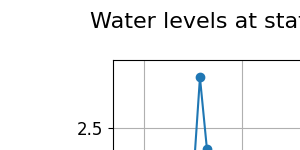

In [7]:
# Creation of an interactive plot with Pandas and Matplotlib

# Hydrometric station to display on the plot
station_displayed_p = stations[1]

# Function to create a plot for the chosen hydrometric station
def interactive_plot(station):
    # Adjusting font and figure size
    params = {
        "legend.fontsize": "14",
        "figure.figsize": (9, 5),
        "axes.labelsize": "14",
        "axes.titlesize": "16",
        "xtick.labelsize": "12",
        "ytick.labelsize": "12",
    }
    plt.rcParams.update(params)
    
    # Creation of the plot
    fig, ax = plt.subplots()
    line, = plt.plot(
        hydrometric_data[station].index,
        hydrometric_data[station]["LEVEL"],
        marker="o",
        label="Daily mean",
    )
    plt.legend()
    plt.grid(True, which="both")
    ax.set_title(
        fill(
            "Water levels at station {} ({})".format(
                hydrometric_data[station]["STATION_NAME"][0], station
            ), 60
        )
    )
    ax.set_ylabel("Water level (m)")
    ax.set_xlabel("Date")

    # Modification of the x axis ticks and tick labels
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    # Creation of the annotations to display on hover
    annot = ax.annotate(
        "",
        xy=(0, 0),
        xytext=(-60, -40),
        textcoords="offset points",
        bbox=dict(boxstyle="round", fc="w"),
        arrowprops=dict(arrowstyle="->"),
    )
    annot.set_visible(False)

    return line, annot, ax, fig


# Choosing the hydrometric stations to create the plot
line, annot, ax, fig = interactive_plot(station_displayed_p)


# Updating the annotation with the data point information
def update_annot(ind):
    # Identifying the annotation to display
    x, y = line.get_data()
    annot.xy = (x[ind["ind"][0]], y[ind["ind"][0]])
    
    # Adding text to the annotation (date and water level)
    date_x = x[ind["ind"]][0]
    level_y = round(y[ind["ind"]][0], 2)
    text = "{}\nDaily mean: {} m".format(date_x, level_y)
    annot.set_text(text)
    
    # Setting annotation transparency
    annot.get_bbox_patch().set_alpha(0.8)


# Display of annotations on hover
def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = line.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()


# Adding the feature that displays annotations on hover               
fig.canvas.mpl_connect("motion_notify_event", hover)

plt.show()

**Important note:** For the annotations to appear on mouse hover, the code needs to be executed on your computer or [in a Jupyter Notebook](https://mybinder.org/v2/gh/marieevelb/oafeat-use-case/main?filepath=docs%2Fuse-case_oafeat-script_en.ipynb).  If the annotations are not visible when hovering over data points in a Jupyter Notebook, run the cell above again by clicking in the cell and then clicking on the Run button in the menu bar.

The data can also be visualized in a tabular view using Pandas.

In [8]:
# Creation of the table

# Hydrometric station to display in the table
station_displayed_t = stations[1]

# Option to show all rows
pd.set_option("max_rows", None)


# Function to show the table of the chosen hydrometric station
def data_table(station):
    # Print table title
    print(
        "Water level at station "
        + f"{hydrometric_data[station]['STATION_NAME'][0]}"
        + f" ({station})"
    )
    # Selecting the desired columns and changing the columns names
    displayed_df = hydrometric_data[station][["LEVEL"]].round(2).rename(
        columns={
            "LEVEL": "Water level daily mean (m)",
        }
    )
    displayed_df.index = displayed_df.index.rename("Date")
    return displayed_df

print(tabulate(data_table(station_displayed_t),
               headers='keys',
               tablefmt='pretty'))

Water level at station SEYMOUR RIVER NEAR NORTH VANCOUVER (08GA030)
+------------+----------------------------+
|    Date    | Water level daily mean (m) |
+------------+----------------------------+
| 2018-06-01 |            1.58            |
| 2018-06-02 |            1.57            |
| 2018-06-03 |            1.74            |
| 2018-06-04 |            1.94            |
| 2018-06-05 |            1.91            |
| 2018-06-06 |            1.7             |
| 2018-06-07 |            1.67            |
| 2018-06-08 |            2.16            |
| 2018-06-09 |            2.82            |
| 2018-06-10 |            2.37            |
| 2018-06-11 |            2.08            |
| 2018-06-12 |            1.83            |
| 2018-06-13 |            2.02            |
| 2018-06-14 |            2.3             |
| 2018-06-15 |            2.07            |
| 2018-06-16 |            1.96            |
| 2018-06-17 |            2.15            |
| 2018-06-18 |            2.16            |
| 2018-0

Finally, an interactive map can be created with Matplotlib to display the most recent water level daily mean of the hydrometric monitoring stations located within 100 km of Chilliwack for the selected three months period when hovering over the stations. For an interactive map with more features like a zoom control, a scale bar or a full screen option, [ipyleaflet](https://ipyleaflet.readthedocs.io/en/latest/index.html) can be used in a Jupyter Notebook. A usage exemple is available [in the other version of this use case](https://mybinder.org/v2/gh/marieevelb/oafeat-use-case/main?filepath=docs%2Fuse-case_oafeat-interactive_en.ipynb) that demonstrate the interactive GUI possibilities offered by Jupyter Notebook.

<IPython.core.display.Javascript object>


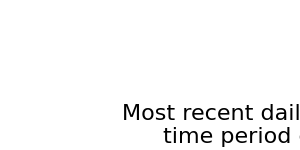

In [9]:
# Creation of the interactive map

# Lists of positions and labels
labels = []
all_lat = []
all_lon = []
for station in stations:
    latest_data = hydrometric_data[station].iloc[-1]
    labels.append(
        f"{hydrometric_data[station]['STATION_NAME'][0]}\n"
        + f"Station ID: {latest_data.STATION_NUMBER}\n"
        + f"Date: {latest_data.name}\n"
        + f"Water level: {round(latest_data.LEVEL, 2)} m"
    )
    all_lat.append(latest_data.LATITUDE)
    all_lon.append(latest_data.LONGITUDE)

# List for keeping track of all annotations
annotations = [None for label in labels]

# Defining size of markers
markersize = 8
markersize_inches = markersize / 72.0

# Setting up figure
tiler = OSM()
fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection=tiler.crs)
ax.set_title(fill(
    "Most recent daily mean water level for the "
    + f"time period ending the {end_date}", 45))

# Setting the extent to see adequately all data points
ax.set_extent(
    [
        min(all_lon) * 1.001,
        max(all_lon) * 0.999,
        min(all_lat) * 0.999,
        max(all_lat) * 1.001,
    ]
)

# Adding a basemap from Open Street Map
ax.add_image(tiler, 9)

# Adding data points
ax.plot(
    all_lon,
    all_lat,
    "bo",
    marker="o",
    mec="k",
    color="RoyalBlue",
    ms=markersize,
    transform=ccrs.Geodetic(),
)

# Figure coordinates in inches
trans = ax.transData + fig.dpi_scale_trans.inverted()


# Function for checking mouse coordinates and annotating
def on_move(event):
    if event.inaxes:
        # Transforming the coordinates in the same projection as the plot
        xproj, yproj = zip(
            *[
                ax.projection.transform_point(x, y, src_crs=ccrs.Geodetic())
                for x, y in zip(all_lon, all_lat)
            ]
        )
        # Event coordinates in inches
        x0, y0 = trans.transform((event.xdata, event.ydata))
        # Data points coordinates in inches
        xfig, yfig = zip(
            *[trans.transform((x, y)) for x, y in zip(xproj, yproj)]
        )
        # Distance of the mouse from the data point
        dists = [math.sqrt((x - x0) ** 2 + (y - y0) ** 2) for x, y in zip(
            xfig, yfig
        )]
        
        # Displaying annotations on hover
        for n, (x, y, dist, label) in enumerate(
                zip(xproj, yproj, dists, labels)
        ):
            if dist < markersize_inches and annotations[n] is None:
                annotations[n] = ax.annotate(
                    label,
                    [x, y],
                    xycoords="data",
                    xytext=(10, 10),
                    textcoords="offset points",
                    ha="center",
                    va="bottom",
                    bbox=dict(
                        facecolor="white",
                        edgecolor="black",
                        boxstyle="round"
                    ),
                    zorder=10,
                )
                fig.canvas.draw()

            elif dist > markersize_inches and annotations[n] is not None:
                annotations[n].remove()
                annotations[n] = None
                fig.canvas.draw()


# Connecting the event handler
cid = fig.canvas.mpl_connect("motion_notify_event", on_move)

plt.show()

**Important note:** For the annotations to appear on mouse hover, the code needs to be executed on your computer or [in a Jupyter Notebook](https://mybinder.org/v2/gh/marieevelb/oafeat-use-case/main?filepath=docs%2Fuse-case_oafeat-script_en.ipynb). If the annotations are not visible when hovering over data points in a Jupyter Notebook, run the cell above again by clicking in the cell and then clicking on the Run button in the menu bar.

## Conclusion

Cathy has now a good overview of the water levels of the rivers and lakes near her. This information will help her plan her boat tours and water sports company activities. After completing this use case, you should be able to use Python to retrieve and process geospatial data from GeoMet-OGC-API and to display data in different formats (interactive plot, table and interactive map). This use case can be adapted to fit your needs by changing the parameters or modifying the data processing steps.